In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

df = pd.read_csv("combined_nissan_leaf.csv")

# Drop unnecessary columns
drop_cols = [
    'cars_by_speed_interval_0_80', 'cars_by_speed_interval_80_100', 'cars_by_speed_interval_100_120',
    'cars_by_speed_interval_0_50', 'cars_by_speed_interval_50_80', 'cars_by_speed_interval_80_120',
    'cars_by_speed_interval_120_inf', 'cars_by_length_interval_0_7', 'cars_by_length_interval_7_inf',
    "wind_mph", "wind_kph", "wind_degree", "wind_dir", "Veh_deg", "totalVehicles", "speedAvg", "max_speed",
    "radius", "timestamp_weather_utc", "car_description", "car_code", "route_description", "point_geom",
    "latitude", "longitude", "route_id", "timestamp_gps_utc", "time_diff", "car_id", "start_timestamp", "end_timestamp"
]
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Fill missing values by group
group_keys = ['soc', 'route_code', 'driver']
for col in df.select_dtypes(include=['number']).columns:
    df[col] = df.groupby(group_keys)[col].transform(lambda x: x.fillna(x.mean()))

# One-hot encode driver and label encode route_code
df = pd.get_dummies(df, columns=['driver'], prefix='driver')
df['route_code'] = LabelEncoder().fit_transform(df['route_code'].astype(str))

# Create range column
df['speed_mps'] = df['speed'] * (5/18)
df['range'] = df['speed_mps'] / (60/7)
df.drop(columns=['speed_mps'], inplace=True)

# Save for later use
df.to_csv("cleaned_leaf.csv", index=False)


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df = pd.read_csv("cleaned_leaf.csv")
df['timestamp_data_utc'] = pd.to_datetime(df['timestamp_data_utc'])
df.sort_values(by=['route_code', 'timestamp_data_utc'], inplace=True)

feature_cols = [col for col in df.columns if col not in ['timestamp_data_utc', 'range']]
target_col = 'range'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

df_scaled = df.copy()
df_scaled[feature_cols] = scaler_X.fit_transform(df_scaled[feature_cols])
df_scaled[target_col] = scaler_y.fit_transform(df_scaled[[target_col]])

def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('route_code'):
        data = group.sort_values('timestamp_data_utc')
        features = data[feature_cols].values
        target = data[target_col].values
        for i in range(len(features) - seq_len):
            X.append(features[i:i+seq_len])
            y.append(target[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 10
X, y = create_sequences(df_scaled, seq_len, feature_cols, target_col)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


C:\Users\ashis\AppData\Local\Temp\ipykernel_18308\1875698382.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['timestamp_data_utc'] = pd.to_datetime(df['timestamp_data_utc'])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = BiLSTMModel(input_size=X_train.shape[2], hidden_size=100, num_layers=2, dropout=0.3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 500
batch_size = 64

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()


Training Epochs: 100%|██████████| 500/500 [09:07<00:00,  1.09s/it]


In [4]:
model.eval()
with torch.no_grad():
    lstm_preds = model(X_test_tensor).cpu().numpy().flatten()
    y_test_np = y_test_tensor.cpu().numpy().flatten()


In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Prepare input (same as before)
X_gb = np.hstack([X_test.reshape(X_test.shape[0], -1), lstm_preds.reshape(-1, 1)])

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Initialize model
gb_model = GradientBoostingRegressor(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit
grid_search.fit(X_gb, y_test_np)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))


Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# --- Flatten the sequence input for gradient boosting ---
X_gb = np.hstack([X_test.reshape(X_test.shape[0], -1), lstm_preds.reshape(-1, 1)])

# --- Train Gradient Boosting model ---
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_gb, y_test_np)

# --- Predict and evaluate ---
gb_preds = gb_model.predict(X_gb)

mse = mean_squared_error(y_test_np, gb_preds)
mae = mean_absolute_error(y_test_np, gb_preds)
r2 = r2_score(y_test_np, gb_preds)

# --- Print metrics ---
print(f"Gradient Boosted with LSTM Output:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")


Gradient Boosted with LSTM Output:
Mean Squared Error (MSE): 0.0012
Mean Absolute Error (MAE): 0.0267
R^2 Score: 0.9815


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Convert tensors to numpy arrays
y_true = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())
lstm_pred = scaler_y.inverse_transform(lstm_preds.reshape(-1, 1))
gbt_pred = scaler_y.inverse_transform(gb_preds.reshape(-1, 1))

# Ensure the target folder exists
unnamed_folder = os.path.join("images", "unamed_png")
os.makedirs(unnamed_folder, exist_ok=True)

# ---------- 1. LSTM vs Actual ----------
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual', alpha=0.7)
plt.plot(lstm_pred, label='LSTM Prediction', alpha=0.7)
plt.xlabel("Samples", fontsize=16)
plt.ylabel("Range", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(unnamed_folder, "lstm_vs_actual.svg"), format="svg")
plt.savefig(os.path.join(unnamed_folder, "lstm_vs_actual.png"), format="png")
plt.close()

# ---------- 2. GBT (Final) vs Actual ----------
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual', alpha=0.7)
plt.plot(gbt_pred, label='Stacked LSTM+GBT Prediction', alpha=0.7)
plt.xlabel("Samples", fontsize=16)
plt.ylabel("Range", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(unnamed_folder, "gbt_vs_actual.svg"), format="svg")
plt.savefig(os.path.join(unnamed_folder, "gbt_vs_actual.png"), format="png")
plt.close()

print("✅ Plots saved to:", unnamed_folder)


✅ Plots saved to: images\unamed_png


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Convert tensors to numpy arrays
y_true = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())
lstm_pred = scaler_y.inverse_transform(lstm_preds.reshape(-1, 1))
gbt_pred = scaler_y.inverse_transform(gb_preds.reshape(-1, 1))

# Ensure the target folder exists
unnamed_folder = os.path.join("images", "unamed_png")
os.makedirs(unnamed_folder, exist_ok=True)

# Create a single figure with 2 vertically stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Plot 1: LSTM vs Actual ---
axes[0].plot(y_true, label='Actual', alpha=0.7)
axes[0].plot(lstm_pred, label='LSTM Prediction', alpha=0.7)
axes[0].set_ylabel("Range", fontsize=16)
axes[0].legend(fontsize=14)
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_title("LSTM vs Actual", fontsize=14)

# --- Plot 2: GBT vs Actual ---
axes[1].plot(y_true, label='Actual', alpha=0.7)
axes[1].plot(gbt_pred, label='Gradient Boosted Prediction', alpha=0.7)
axes[1].set_xlabel("Samples", fontsize=16)
axes[1].set_ylabel("Range", fontsize=16)
axes[1].legend(fontsize=14)
axes[1].grid(True)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_title("GBT + LSTM vs Actual", fontsize=14)

plt.tight_layout()
combined_path_svg = os.path.join(unnamed_folder, "combined_lstm_gbt_vs_actual.svg")
combined_path_png = os.path.join(unnamed_folder, "combined_lstm_gbt_vs_actual.png")
plt.savefig(combined_path_svg, format="svg")
plt.savefig(combined_path_png, format="png", dpi=300)
plt.close()

print("✅ Combined plot saved to:", unnamed_folder)


✅ Combined plot saved to: images\unamed_png


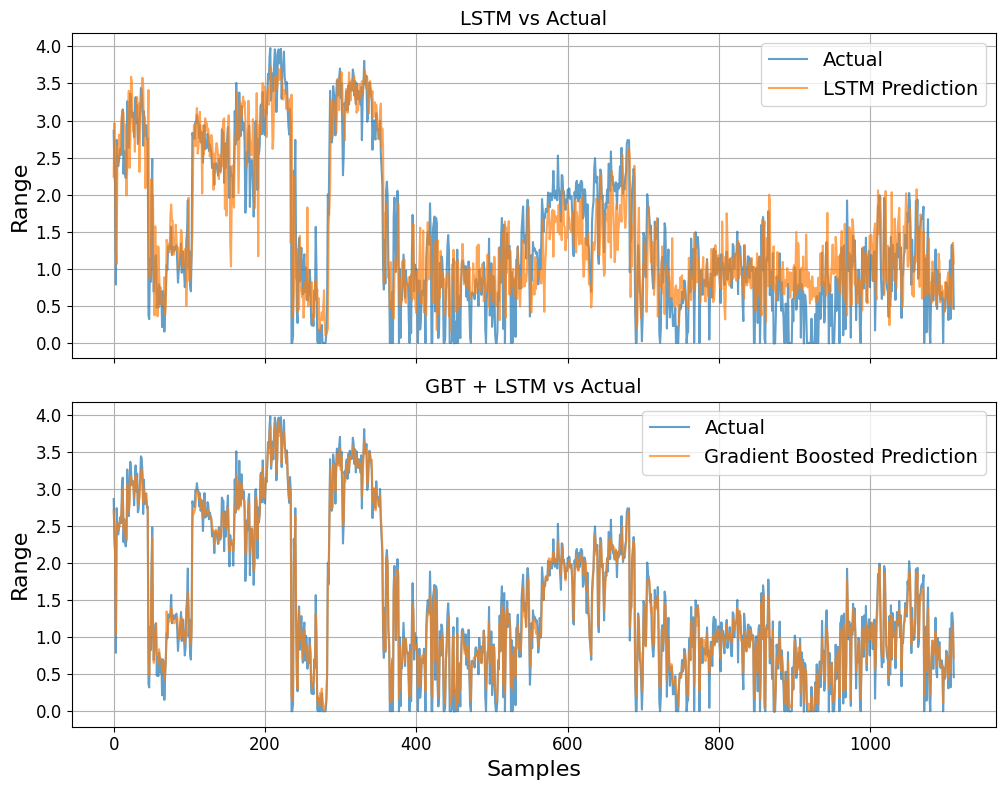

✅ Combined plot saved to: images\unamed_png


In [9]:
# Jupyter magic command to display plots inline
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os

# Convert tensors to numpy arrays
y_true = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())
lstm_pred = scaler_y.inverse_transform(lstm_preds.reshape(-1, 1))
gbt_pred = scaler_y.inverse_transform(gb_preds.reshape(-1, 1))

# Ensure the target folder exists
unnamed_folder = os.path.join("images", "unamed_png")
os.makedirs(unnamed_folder, exist_ok=True)

# Create a single figure with 2 vertically stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Plot 1: LSTM vs Actual ---
axes[0].plot(y_true, label='Actual', alpha=0.7)
axes[0].plot(lstm_pred, label='LSTM Prediction', alpha=0.7)
axes[0].set_ylabel("Range", fontsize=16)
axes[0].legend(fontsize=14)
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_title("LSTM vs Actual", fontsize=14)

# --- Plot 2: GBT vs Actual ---
axes[1].plot(y_true, label='Actual', alpha=0.7)
axes[1].plot(gbt_pred, label='Gradient Boosted Prediction', alpha=0.7)
axes[1].set_xlabel("Samples", fontsize=16)
axes[1].set_ylabel("Range", fontsize=16)
axes[1].legend(fontsize=14)
axes[1].grid(True)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_title("GBT + LSTM vs Actual", fontsize=14)

plt.tight_layout()

# Save plots
combined_path_svg = os.path.join(unnamed_folder, "combined_lstm_gbt_vs_actual.svg")
combined_path_png = os.path.join(unnamed_folder, "combined_lstm_gbt_vs_actual.png")
plt.savefig(combined_path_svg, format="svg")
plt.savefig(combined_path_png, format="png", dpi=300)

# Display the plot in the notebook
plt.show()

# Close the figure to free memory
plt.close()

print("✅ Combined plot saved to:", unnamed_folder)


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Calculate residuals
lstm_residuals = y_true.flatten() - lstm_pred.flatten()
hybrid_residuals = y_true.flatten() - gbt_pred.flatten()

# Ensure the target folder exists
unnamed_folder = os.path.join("images", "unamed_png")
os.makedirs(unnamed_folder, exist_ok=True)

# ---------- 1. Scatter Plot of Residuals ----------
plt.figure(figsize=(10, 4))
plt.scatter(range(len(lstm_residuals)), lstm_residuals, alpha=0.6, label='LSTM Residuals', s=20)
plt.scatter(range(len(hybrid_residuals)), hybrid_residuals, alpha=0.6, label='GBT+LSTM Residuals', s=20)
plt.axhline(0, color='gray', linestyle='--', linewidth=1.2)
plt.xlabel("Samples", fontsize=18)
plt.ylabel("Residual", fontsize=18)
plt.legend(fontsize=16)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(unnamed_folder, "residuals_scatter.svg"), format="svg")
plt.savefig(os.path.join(unnamed_folder, "residuals_scatter.png"), format="png")
plt.close()

# ---------- 2. Distribution Plot of Residuals ----------
plt.figure(figsize=(10, 4))
sns.kdeplot(lstm_residuals, label="LSTM Residuals", fill=True, alpha=0.5, linewidth=2)
sns.kdeplot(hybrid_residuals, label="GBT+LSTM Residuals", fill=True, alpha=0.5, linewidth=2)
plt.xlabel("Residual", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(unnamed_folder, "residuals_distribution.svg"), format="svg")
plt.savefig(os.path.join(unnamed_folder, "residuals_distribution.png"), format="png")
plt.close()

print("✅ Residual plots saved to:", unnamed_folder)


✅ Residual plots saved to: images\unamed_png


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Create output folder
unnamed_png_folder = os.path.join("images", "unamed_png")
os.makedirs(unnamed_png_folder, exist_ok=True)

# Convert tensors to numpy arrays
y_true = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())
lstm_pred = scaler_y.inverse_transform(lstm_preds.reshape(-1, 1))
gbt_pred = scaler_y.inverse_transform(gb_preds.reshape(-1, 1))

# ---------- 1. LSTM vs Actual ----------
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual', alpha=0.7)
plt.plot(lstm_pred, label='LSTM Prediction', alpha=0.7)

plt.xlabel("Samples", fontsize=12)
plt.ylabel("Range", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=9)
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.6)
plt.tight_layout()

path_lstm = os.path.join(unnamed_png_folder, "lstm_vs_actual.png")
plt.savefig(path_lstm, format="png", dpi=300, bbox_inches="tight")
print(f"✅ PNG saved at: {path_lstm}")
plt.close()

# ---------- 2. GBT (Final) vs Actual ----------
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual', alpha=0.7)
plt.plot(gbt_pred, label='Stacked Model Prediction(LSTM+GBT)', alpha=0.7)

plt.xlabel("Samples", fontsize=12)
plt.ylabel("Range", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=9)
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.6)
plt.tight_layout()

path_gbt = os.path.join(unnamed_png_folder, "gbt_vs_actual.png")
plt.savefig(path_gbt, format="png", dpi=300, bbox_inches="tight")
print(f"✅ PNG saved at: {path_gbt}")
plt.close()


✅ PNG saved at: images\unamed_png\lstm_vs_actual.png
✅ PNG saved at: images\unamed_png\gbt_vs_actual.png


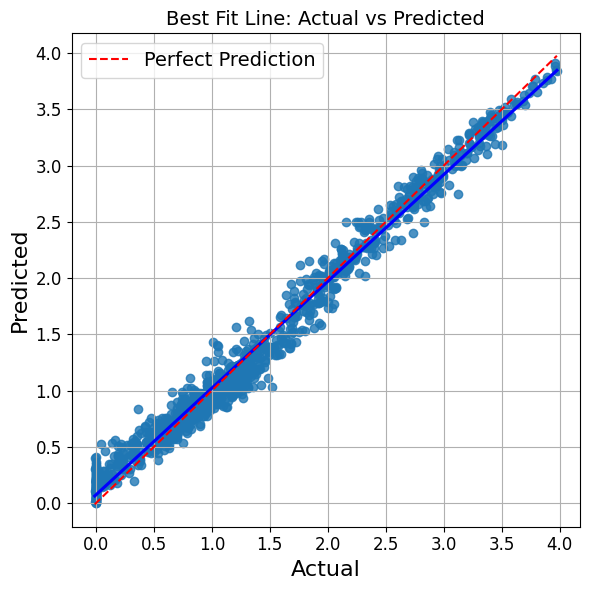

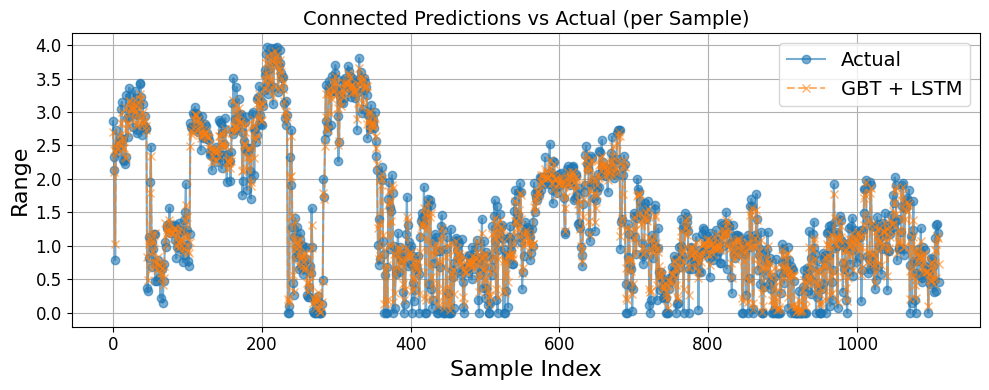

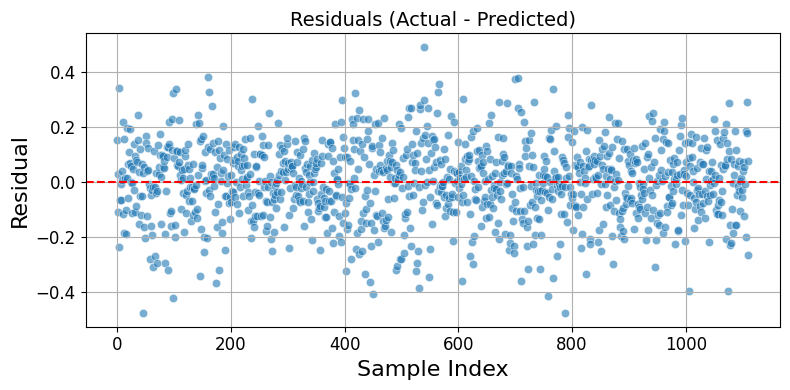

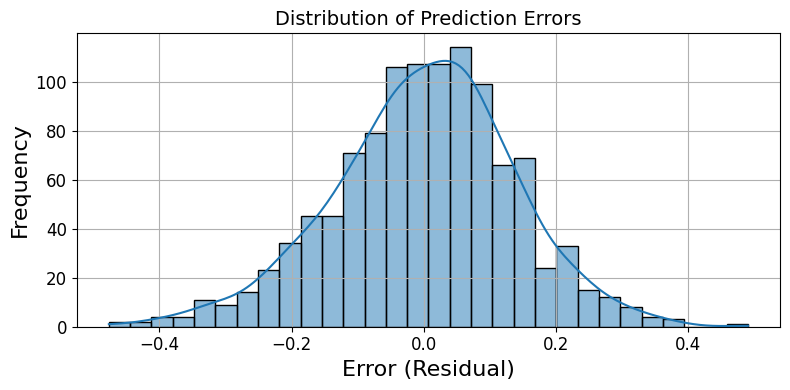

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 4. Line of Best Fit ----------
plt.figure(figsize=(6, 6))
sns.regplot(x=y_true.flatten(), y=gbt_pred.flatten(), ci=None, line_kws={"color": "blue"})
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
plt.title("Best Fit Line: Actual vs Predicted", fontsize=14)
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# ---------- 5. Actual vs Predicted with Connected Points ----------
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual', marker='o', linestyle='-', alpha=0.6)
plt.plot(gbt_pred, label='GBT + LSTM', marker='x', linestyle='--', alpha=0.6)
plt.title("Connected Predictions vs Actual (per Sample)", fontsize=14)
plt.xlabel("Sample Index", fontsize=16)
plt.ylabel("Range", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# ---------- 6. Residual Plot ----------
residuals = y_true.flatten() - gbt_pred.flatten()
plt.figure(figsize=(8, 4))
sns.scatterplot(x=range(len(residuals)), y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals (Actual - Predicted)", fontsize=14)
plt.xlabel("Sample Index", fontsize=16)
plt.ylabel("Residual", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# ---------- 7. Error Distribution ----------
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Prediction Errors", fontsize=14)
plt.xlabel("Error (Residual)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create folder if it doesn't exist
unnamed_folder = os.path.join("images", "unamed_png")
os.makedirs(unnamed_folder, exist_ok=True)

# ---------- 4. Line of Best Fit ----------
plt.figure(figsize=(6, 6))
sns.regplot(x=y_true.flatten(), y=gbt_pred.flatten(), ci=None, line_kws={"color": "blue"})
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual", fontsize=16)
plt.ylabel("Predicted", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(unnamed_folder, "line_of_best_fit.png"), format="png", dpi=300)
plt.close()

# ---------- 5. Actual vs Predicted with Connected Points ----------
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual', marker='o', linestyle='-', alpha=0.6)
plt.plot(gbt_pred, label='GBT + LSTM', marker='x', linestyle='--', alpha=0.6)
plt.xlabel("Sample Index", fontsize=16)
plt.ylabel("Range", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(unnamed_folder, "connected_predictions.png"), format="png", dpi=300)
plt.close()

# ---------- 6. Residual Plot ----------
residuals = y_true.flatten() - gbt_pred.flatten()
plt.figure(figsize=(8, 4))
sns.scatterplot(x=range(len(residuals)), y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Sample Index", fontsize=16)
plt.ylabel("Residual", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(unnamed_folder, "residual_plot.png"), format="png", dpi=300)
plt.close()

# ---------- 7. Error Distribution ----------
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Error (Residual)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(unnamed_folder, "error_distribution.png"), format="png", dpi=300)
plt.close()

print("✅ All plots saved to:", unnamed_folder)


✅ All plots saved to: images\unamed_png


In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Create directory for unnamed pngs
unnamed_png_folder = os.path.join("images", "unamed_png")
os.makedirs(unnamed_png_folder, exist_ok=True)

# Limit to first 100 samples
num_samples = 100
y_true_flat = y_true.flatten()[:num_samples]
gbt_pred_flat = gbt_pred.flatten()[:num_samples]
x_positions = np.arange(num_samples)

# Create a smaller figure for publication
plt.figure(figsize=(5, 4.5))

# Plot actual and predicted values
plt.scatter(x_positions, y_true_flat, color='blue', label='Actual', zorder=3, s=10)
plt.scatter(x_positions, gbt_pred_flat, color='red', label='Predicted', zorder=3, s=10)

# Connecting lines
for i in range(num_samples):
    plt.plot([x_positions[i], x_positions[i]], [y_true_flat[i], gbt_pred_flat[i]], 
             color='gray', alpha=0.5, linewidth=0.5)

# Set labels and styles
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Range', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=9)
plt.grid(True, linewidth=0.3, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save only PNG (no EPS)
save_path = os.path.join(unnamed_png_folder, "actual_vs_predicted_connected_100.png")
plt.savefig(save_path, format="png", dpi=300, bbox_inches="tight")

print(f"✅ PNG saved at: {save_path}")
plt.close()


✅ PNG saved at: images\unamed_png\actual_vs_predicted_connected_100.png


In [24]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create folder if it doesn't exist
unnamed_png_folder = os.path.join("images", "unamed_png")
os.makedirs(unnamed_png_folder, exist_ok=True)

# --------- 1. Line of Best Fit ---------
plt.figure(figsize=(5, 4.5))
sns.regplot(x=y_true.flatten(), y=gbt_pred.flatten(), ci=None, line_kws={"color": "blue"})
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.path.join(unnamed_png_folder, "line_of_best_fit.png"), format="png", dpi=300, bbox_inches="tight")
plt.close()

# --------- 2. Connected Actual vs Predicted ---------
plt.figure(figsize=(5, 4.5))
plt.plot(y_true, label='Actual', marker='o', linestyle='-', alpha=0.6)
plt.plot(gbt_pred, label='GBT + LSTM', marker='x', linestyle='--', alpha=0.6)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Range", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.path.join(unnamed_png_folder, "connected_actual_vs_predicted.png"), format="png", dpi=300, bbox_inches="tight")
plt.close()

# --------- 3. Residual Plot ---------
residuals = y_true.flatten() - gbt_pred.flatten()
plt.figure(figsize=(5, 4.5))
sns.scatterplot(x=range(len(residuals)), y=residuals, alpha=0.6, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.path.join(unnamed_png_folder, "residuals_scatter.png"), format="png", dpi=300, bbox_inches="tight")
plt.close()

# --------- 4. Error Distribution ---------
plt.figure(figsize=(5, 4.5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Error (Residual)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.path.join(unnamed_png_folder, "residuals_histogram.png"), format="png", dpi=300, bbox_inches="tight")
plt.close()


# FINAL MODEL

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Read the CSV file
df = pd.read_csv("combined_nissan_leaf.csv")

# Drop unnecessary columns
drop_cols = [
    'cars_by_speed_interval_0_80', 'cars_by_speed_interval_80_100', 'cars_by_speed_interval_100_120',
    'cars_by_speed_interval_0_50', 'cars_by_speed_interval_50_80', 'cars_by_speed_interval_80_120',
    'cars_by_speed_interval_120_inf', 'cars_by_length_interval_0_7', 'cars_by_length_interval_7_inf',
    "wind_mph", "wind_kph", "wind_degree", "wind_dir", "Veh_deg", "totalVehicles", "speedAvg", "max_speed",
    "radius", "timestamp_weather_utc", "car_description", "car_code", "route_description", "point_geom",
    "latitude", "longitude", "route_id", "timestamp_gps_utc", "time_diff", "car_id", "start_timestamp", "end_timestamp"
]
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Fill missing values by group using 'soc', 'route_code', and 'driver'
group_keys = ['soc', 'route_code', 'driver']
for col in df.select_dtypes(include=['number']).columns:
    df[col] = df.groupby(group_keys)[col].transform(lambda x: x.fillna(x.mean()))

# Compute the standard deviation of speed for each (route_code, driver) group.
# Do this before one-hot encoding 'driver' so that we retain the original labels.
df['speed_std'] = df.groupby(['route_code', 'driver'])['speed'].transform('std')
# Optionally, fill NaN values with 0 (which occur if a group has only one record)
df['speed_std'] = df['speed_std'].fillna(0)

# One-hot encode 'driver' and label encode 'route_code'
df = pd.get_dummies(df, columns=['driver'], prefix='driver')
df['route_code'] = LabelEncoder().fit_transform(df['route_code'].astype(str))

# Create range column based on speed (converted to meters per second)
df['speed_mps'] = df['speed'] * (5/18)
df['range'] = df['speed_mps'] / (60/7)
df.drop(columns=['speed_mps'], inplace=True)

# Save the cleaned dataframe with the new speed_std feature for later use
df.to_csv("cleaned_leaf_with_speed_std_dev.csv", index=False)


In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df = pd.read_csv("cleaned_leaf_with_speed_std_dev.csv")
df['timestamp_data_utc'] = pd.to_datetime(df['timestamp_data_utc'])
df.sort_values(by=['route_code', 'timestamp_data_utc'], inplace=True)

feature_cols = [col for col in df.columns if col not in ['timestamp_data_utc', 'range']]
target_col = 'range'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

df_scaled = df.copy()
df_scaled[feature_cols] = scaler_X.fit_transform(df_scaled[feature_cols])
df_scaled[target_col] = scaler_y.fit_transform(df_scaled[[target_col]])

def create_sequences(df, seq_len, feature_cols, target_col):
    X, y = [], []
    for _, group in df.groupby('route_code'):
        data = group.sort_values('timestamp_data_utc')
        features = data[feature_cols].values
        target = data[target_col].values
        for i in range(len(features) - seq_len):
            X.append(features[i:i+seq_len])
            y.append(target[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 10
X, y = create_sequences(df_scaled, seq_len, feature_cols, target_col)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


C:\Users\ashis\AppData\Local\Temp\ipykernel_4552\3968779599.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['timestamp_data_utc'] = pd.to_datetime(df['timestamp_data_utc'])


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = BiLSTMModel(input_size=X_train.shape[2], hidden_size=100, num_layers=2, dropout=0.3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 500
batch_size = 64

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epochs: 100%|██████████| 500/500 [02:38<00:00,  3.15it/s]


In [11]:
model.eval()
with torch.no_grad():
    lstm_preds = model(X_test_tensor).cpu().numpy().flatten()
    y_test_np = y_test_tensor.cpu().numpy().flatten()


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Flatten the sequence input for gradient boosting
X_gb = np.hstack([X_test.reshape(X_test.shape[0], -1), lstm_preds.reshape(-1, 1)])

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
gb_model.fit(X_gb, y_test_np)

# Predict and evaluate
gb_preds = gb_model.predict(X_gb)

mse = mean_squared_error(y_test_np, gb_preds)
mae = mean_absolute_error(y_test_np, gb_preds)
r2 = r2_score(y_test_np, gb_preds)

print(f"Gradient Boosted with LSTM Output:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")


Gradient Boosted with LSTM Output:
Mean Squared Error: 0.0013
Mean Absolute Error: 0.0278
R^2 Score: 0.9799


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert tensors to numpy arrays
y_true = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())
lstm_pred = scaler_y.inverse_transform(lstm_preds.reshape(-1, 1))
gbt_pred = scaler_y.inverse_transform(gb_preds.reshape(-1, 1))  # ✅ use gb_preds here

# ---------- 1. LSTM vs Actual ----------
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual', alpha=0.7)
plt.plot(lstm_pred, label='LSTM Prediction', alpha=0.7)
plt.title("LSTM Predictions vs Actual")
plt.xlabel("Samples")
plt.ylabel("Range")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- 2. GBT (Final) vs Actual ----------
plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual', alpha=0.7)
plt.plot(gbt_pred, label='Gradient Boosted Prediction', alpha=0.7)
plt.title("Final GBT + LSTM Predictions vs Actual")
plt.xlabel("Samples")
plt.ylabel("Range")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- 3. Residual Plot ----------
residuals = y_true.flatten() - gbt_pred.flatten()
plt.figure(figsize=(8, 4))
sns.scatterplot(x=range(len(residuals)), y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Sample Index")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- 4. Error Distribution ----------
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Residual)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()




NameError: name 'scaler_y' is not defined

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Create directories for saving the plots
main_folder = "images"
png_folder = os.path.join(main_folder, "png")
eps_folder = os.path.join(main_folder, "eps")
os.makedirs(png_folder, exist_ok=True)
os.makedirs(eps_folder, exist_ok=True)

# Limit to first 500 samples
num_samples = 100
y_true_flat = y_true.flatten()[:num_samples]
gbt_pred_flat = gbt_pred.flatten()[:num_samples]
x_positions = np.arange(num_samples)

# Create a smaller figure for publication
plt.figure(figsize=(5, 4))

# Plot actual and predicted values
plt.scatter(x_positions, y_true_flat, color='blue', label='Actual', zorder=3, s=10)
plt.scatter(x_positions, gbt_pred_flat, color='red', label='Predicted', zorder=3, s=10)

# Connecting lines
for i in range(num_samples):
    plt.plot([x_positions[i], x_positions[i]], [y_true_flat[i], gbt_pred_flat[i]], 
             color='gray', alpha=0.5, linewidth=0.5)

# Set labels and styles
plt.xlabel('Test Sample Index', fontsize=8)
plt.ylabel('Range', fontsize=8)
plt.title('Actual vs Predicted Range (First 100 Samples)', fontsize=9)
plt.legend(fontsize=7)
plt.grid(True, linewidth=0.3)
plt.tight_layout()

# Save plots
png_path = os.path.join(png_folder, "actual_vs_predicted_range_gbt_lstm_500.png")
eps_path = os.path.join(eps_folder, "actual_vs_predicted_range_gbt_lstm_500.eps")
plt.savefig(png_path, format="png", dpi=300, bbox_inches="tight")
plt.savefig(eps_path, format="eps", bbox_inches="tight")

print(f"✅ PNG saved at: {png_path}")
print(f"✅ EPS saved at: {eps_path}")

plt.show()
